# OpenAI GPT2

Импорт основных библиотек

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

Проверка среды и зависимостей

In [2]:
!ls -la

total 82648
drwxr-xr-x 6 root root     4096 Jul 22 14:16 .
drwxr-xr-x 5 root root     4096 Jul 22 10:46 ..
drwxr-xr-x 2 root root     4096 Jul 22 10:46 .virtual_documents
-rw-r--r-- 1 root root 84573029 Jul 22 10:52 best_dense_tagger.pt
drwxr-xr-x 7 root root     4096 Jul 22 13:56 checkpoints
drwxr-xr-x 2 root root     4096 Jul 22 13:08 gpt-2-model
drwxr-xr-x 2 root root     4096 Jul 22 13:08 gpt-2-tokenizer
-rw-r--r-- 1 root root    29680 Jul 22 14:16 requirements.txt


In [3]:
!pip freeze > requirements.txt

In [4]:
!nvidia-smi

Tue Jul 22 15:37:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |    2695MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Импорт библиотек для ML и настройка устройства

In [5]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [6]:
!pip install --upgrade huggingface_hub

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW

# from torch.optim import AdamW

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


## Загрузка и визуализация данных

In [9]:
img_base_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
reports_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')
projections_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

In [10]:
reports_df.shape, projections_df.shape

((3851, 8), (7466, 3))

In [11]:
class ImageCaptionData:
    def __init__(self, reports_df, projections_df):
        self.reports_df = reports_df.set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = reports_df[reports_df.findings.notnull()].uid.unique()
        
    def get_sample(self):
        uid = np.random.choice(self.uids)
        images = list(self.projections_df.loc[[uid]]['filename'])
        projections = list(self.projections_df.loc[[uid]]['projection'])
        findings = self.reports_df.loc[uid]['findings']
        return uid, images, projections, findings

In [12]:
paired_dataset = ImageCaptionData(reports_df, projections_df)
uid, images, projections, findings = paired_dataset.get_sample()

In [13]:
def display_sample(uid, images, projections, findings):
    plt.figure(figsize=(10, 5))
    print("UID:", uid)
    for i, (img, proj) in enumerate(zip(images, projections)):
        plt.subplot(1, len(images), i+1)
        png_img = Image.open(os.path.join(img_base_dir, img))
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print(f"Findings: {findings}")

UID: 465


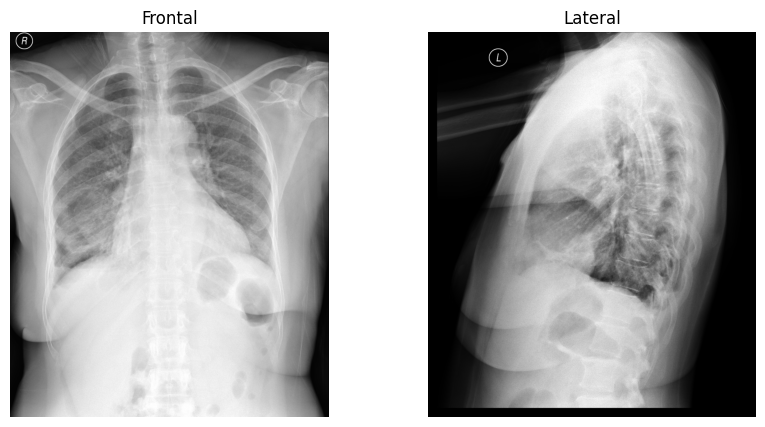

Findings: Normal cardiomediastinal contours. Right lower lung patchy opacities. Small right pneumothorax. Small right pleural effusion.


In [14]:
display_sample(uid, images, projections, findings)

In [15]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

In [16]:
len(train_uids), len(test_uids)

(3465, 386)

## Предварительное Обучение Языковой Модели (GPT-2)

In [17]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [18]:
findings_corpus = [tokenizer.encode(line) for line in reports_df[reports_df.uid.isin(train_uids)].findings.dropna()]

In [19]:
pd.Series([len(x) for x in findings_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3003.000000
mean       51.048618
std        22.007258
min         8.000000
25%        37.000000
50%        48.000000
75%        61.000000
80%        67.000000
90%        80.000000
95%        92.000000
max       238.000000
dtype: float64

In [20]:
class GPT2Dataset(Dataset):
    def __init__(self, txt_list, max_length):
        self.input_ids = [torch.tensor(t[:max_length-1] + [tokenizer.eos_token_id]) for t in txt_list]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index]

In [21]:
def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
    return pad_sequence(batch, batch_first=True, padding_value=pad_id)

In [22]:
# Create dataset
dataset = GPT2Dataset(findings_corpus, max_length=128)  # Adjust max_length as needed
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)

In [23]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

In [24]:
sample_reports = list(reports_df[reports_df["uid"].isin(test_uids)]["findings"].dropna().sample(5))

In [25]:
sample_reports

['The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax. Degenerative disease of multiple midthoracic vertebral bodies.',
 'The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.',
 'The heart is normal in size. The mediastinal contours are within normal limits. Aorta is mildly tortuous and demonstrates atherosclerotic calcifications. The lungs are mildly hypoinflated with increased peripheral lung markings noted predominantly in the right upper and lower lung. There is no acute infiltrate or significant pleural effusion. Mild eventration of left hemidiaphragm is noted.',
 'Cardiomediastinal silhouette is normal. Pulmonary vasculature and XXXX are normal. No consolidation, pneumothorax or large pleural effusion. Postsurgical changes of the cervical spine are present

In [26]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids = encoded_input,
            max_length = 100,  # Total length of output text (including the prompt)
            num_return_sequences = 1,  # Number of sequences to generate
            temperature = 0.7,  # Sampling temperature
            top_k = 50,  # Top-k filtering
            top_p = 0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size = 2,  # Prevent repetitions of n-grams
            pad_token_id = tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)

In [27]:
!pip install -U nltk -q
!pip install rouge_score bert_score -q

In [28]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score

import nltk
nltk.download('wordnet', download_dir='/usr/local/share/nltk_data')

[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
# Инициализация скореров
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Расчет метрик для каждой пары сгенерированного и исходного текста
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    
    # BLEU
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([smp.split()], gen.split(), weights=weights, smoothing_function=smoothie)
        print(f"BLEU-{i} score:", bleu_score)

    # ROUGE
    scores = scorer.score(smp, gen)
    print("ROUGE-1: ", scores['rouge1'])
    print("ROUGE-2: ", scores['rouge2'])
    print("ROUGE-L: ", scores['rougeL'])
    
    # BERTScore
    P, R, F1 = bert_score([gen], [smp], lang="en")
    print("BERTScore: ", F1.item())

    print("------------")


Sample report:
 The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax. Degenerative disease of multiple midthoracic vertebral bodies.
Generated report:
 The heart and mediastinum are the two main components of the brain. The heart is the most important organ in the body, and the mediostin is responsible for the regulation of blood flow.

The mediosteroid system is a complex system that includes the hypothalamus, the pituitary gland, pitocortical and adrenal glands, adrenocervical, endocrine, immune, thyroid, liver, kidney, pancreas, heart, brain, spinal cord,
BLEU-1 score: 0.12903225806451615
BLEU-2 score: 0.0919844099636548
BLEU-3 score: 0.07506995451307417
BLEU-4 score: 0.061538103874647754
ROUGE-1:  Score(precision=0.14516129032258066, recall=0.36, fmeasure=0.20689655172413796)
ROUGE-2:  Score(precision=0.06557377049180328, recall=0.16666666666666666, fmeasure=0.09411764705882354)
ROUGE-L:  Score(precision=0.12903225

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8232924342155457
------------
Sample report:
 The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.
Generated report:
 The lungs are clear. There is no blood. The lungs have no oxygen.

The heart is clear, but there is a small amount of blood in the lungs. It is not clear what is going on. I am not sure what the cause is. If it is something that is happening, I don't know. But I do know that there are some things that are happening. And I know there will be some people who will say, "Well, that's not what I'm
BLEU-1 score: 0.19512195121951223
BLEU-2 score: 0.14724203476646205
BLEU-3 score: 0.1175912376661109
BLEU-4 score: 0.09525536512514801
ROUGE-1:  Score(precision=0.2, recall=0.53125, fmeasure=0.2905982905982906)
ROUGE-2:  Score(precision=0.11904761904761904, recall=0.3225806451612903, fmeasure=0.17391304347826086

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.838532030582428
------------
Sample report:
 The heart is normal in size. The mediastinal contours are within normal limits. Aorta is mildly tortuous and demonstrates atherosclerotic calcifications. The lungs are mildly hypoinflated with increased peripheral lung markings noted predominantly in the right upper and lower lung. There is no acute infiltrate or significant pleural effusion. Mild eventration of left hemidiaphragm is noted.
Generated report:
 The heart is normal in the brain, but it's not normal for the heart to be in a state of full-blown cardiac arrest.

The researchers found that the cardiac arrhythmia was associated with a higher risk of heart failure. The researchers also found a lower risk for heart attack. They also noted that heart attacks are more common in people with diabetes, which is a condition that causes heart disease.
BLEU-1 score: 0.22857142857142856
BLEU-2 score: 0.12869789041755736
BLEU-3 score: 0.09007101692842762
BLEU-4 score: 0.0683404128

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8125932216644287
------------
Sample report:
 Cardiomediastinal silhouette is normal. Pulmonary vasculature and XXXX are normal. No consolidation, pneumothorax or large pleural effusion. Postsurgical changes of the cervical spine are present.
Generated report:
 Cardiomediastinal silhouette is normal. Pulmonary function is not affected.

The patient is in good health. The patient has no signs of any serious medical problems.
BLEU-1 score: 0.24
BLEU-2 score: 0.19999999999999998
BLEU-3 score: 0.17344074753167202
BLEU-4 score: 0.14757581190431862
ROUGE-1:  Score(precision=0.32, recall=0.32, fmeasure=0.32)
ROUGE-2:  Score(precision=0.16666666666666666, recall=0.16666666666666666, fmeasure=0.16666666666666666)
ROUGE-L:  Score(precision=0.28, recall=0.28, fmeasure=0.28)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8940752744674683
------------
Sample report:
 The heart size and pulmonary vascularity appear within normal limits. The thoracic aorta is prominent with calcification within the aorta. Azygos lobe is noted. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Degenerative changes noted in the spine.
Generated report:
 The heart size and pulmonary function of the patient are not known.

The patient's blood pressure is normal. The patient is breathing normally. There is no evidence of any abnormal blood flow.
BLEU-1 score: 0.2577334795466146
BLEU-2 score: 0.15118348487970398
BLEU-3 score: 0.11624726870628962
BLEU-4 score: 0.09289235217952214
ROUGE-1:  Score(precision=0.45454545454545453, recall=0.3409090909090909, fmeasure=0.3896103896103896)
ROUGE-2:  Score(precision=0.125, recall=0.09302325581395349, fmeasure=0.10666666666666666)
ROUGE-L:  Score(precision=0.30303030303030304, recall=0.22727272727272727, fmeasure=0.25974025974025977)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.862104594707489
------------


Дообучение GPT-2

In [30]:
model.train()
# optimizer = AdamW(model.parameters(), lr=5e-5)  # Было в прошлом ноутбуке
optimizer = AdamW(model.parameters(), lr=5e-5)

NUM_EPOCHS = 3
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(batch.to(device), labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} completed')

  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 0 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 1 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 2 completed


In [31]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids = encoded_input,
            max_length = 100,  # Total length of output text (including the prompt)
            num_return_sequences = 1,  # Number of sequences to generate
            temperature = 0.7,  # Sampling temperature
            top_k = 50,  # Top-k filtering
            top_p = 0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size = 2,  # Prevent repetitions of n-grams
            pad_token_id = tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax. Degenerative disease of multiple midthoracic vertebral bodies.
Generated report:
 The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax.
------------
Sample report:
 The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.
Generated report:
 The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. Arthritic changes of the skeletal structures are noted.
------------
Sample report:
 The heart is normal in size. The mediastinal contours are within normal limits. Aorta is mildly tortuous and demonstrates atherosclerotic calcifications. The lungs are mildly hypoinflated with increased perip

In [32]:
# Инициализация скореров
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Расчет метрик для каждой пары сгенерированного и исходного текста
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    
    # BLEU
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([smp.split()], gen.split(), weights=weights, smoothing_function=smoothie)
        print(f"BLEU-{i} score:", bleu_score)

    # ROUGE
    scores = scorer.score(smp, gen)
    print("ROUGE-1: ", scores['rouge1'])
    print("ROUGE-2: ", scores['rouge2'])
    print("ROUGE-L: ", scores['rougeL'])
    
    # BERTScore
    P, R, F1 = bert_score([gen], [smp], lang="en")
    print("BERTScore: ", F1.item())

    print("------------")

Sample report:
 The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax. Degenerative disease of multiple midthoracic vertebral bodies.
Generated report:
 The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax.
BLEU-1 score: 0.6778095780054504
BLEU-2 score: 0.6778095780054504
BLEU-3 score: 0.6778095780054504
BLEU-4 score: 0.6778095780054504
ROUGE-1:  Score(precision=1.0, recall=0.72, fmeasure=0.8372093023255813)
ROUGE-2:  Score(precision=1.0, recall=0.7083333333333334, fmeasure=0.8292682926829268)
ROUGE-L:  Score(precision=1.0, recall=0.72, fmeasure=0.8372093023255813)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9625003933906555
------------
Sample report:
 The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.
Generated report:
 The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. Arthritic changes of the skeletal structures are noted.
BLEU-1 score: 0.6650896924810384
BLEU-2 score: 0.6308266913196849
BLEU-3 score: 0.6057771913733552
BLEU-4 score: 0.5817698613390823
ROUGE-1:  Score(precision=0.88, recall=0.6875, fmeasure=0.7719298245614036)
ROUGE-2:  Score(precision=0.7916666666666666, recall=0.6129032258064516, fmeasure=0.6909090909090909)
ROUGE-L:  Score(precision=0.88, recall=0.6875, fmeasure=0.7719298245614036)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9575361013412476
------------
Sample report:
 The heart is normal in size. The mediastinal contours are within normal limits. Aorta is mildly tortuous and demonstrates atherosclerotic calcifications. The lungs are mildly hypoinflated with increased peripheral lung markings noted predominantly in the right upper and lower lung. There is no acute infiltrate or significant pleural effusion. Mild eventration of left hemidiaphragm is noted.
Generated report:
 The heart is normal in size. The mediastinum is unremarkable. There is no pleural effusion, pneumothorax, or focal airspace disease.
BLEU-1 score: 0.10744427734403127
BLEU-2 score: 0.0864758429078748
BLEU-3 score: 0.07441253421142058
BLEU-4 score: 0.06327101799259256
ROUGE-1:  Score(precision=0.7, recall=0.25, fmeasure=0.3684210526315789)
ROUGE-2:  Score(precision=0.47368421052631576, recall=0.16363636363636364, fmeasure=0.24324324324324323)
ROUGE-L:  Score(precision=0.65, recall=0.23214285714285715, fmeasure=0.3421052631

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8794015049934387
------------
Sample report:
 Cardiomediastinal silhouette is normal. Pulmonary vasculature and XXXX are normal. No consolidation, pneumothorax or large pleural effusion. Postsurgical changes of the cervical spine are present.
Generated report:
 Cardiomediastinal silhouette is normal. Pulmonary vasculature is within normal limits. No focal consolidation, pneumothorax or large pleural effusion. Osseous structures are grossly intact.
BLEU-1 score: 0.5580016229720353
BLEU-2 score: 0.48219646459819615
BLEU-3 score: 0.4330300144351847
BLEU-4 score: 0.3865695385532104
ROUGE-1:  Score(precision=0.6521739130434783, recall=0.6, fmeasure=0.6250000000000001)
ROUGE-2:  Score(precision=0.45454545454545453, recall=0.4166666666666667, fmeasure=0.43478260869565216)
ROUGE-L:  Score(precision=0.6521739130434783, recall=0.6, fmeasure=0.6250000000000001)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9470643997192383
------------
Sample report:
 The heart size and pulmonary vascularity appear within normal limits. The thoracic aorta is prominent with calcification within the aorta. Azygos lobe is noted. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Degenerative changes noted in the spine.
Generated report:
 The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.
BLEU-1 score: 0.44895976992951286
BLEU-2 score: 0.43870999591751836
BLEU-3 score: 0.427757668876892
BLEU-4 score: 0.41600146281834716
ROUGE-1:  Score(precision=1.0, recall=0.5681818181818182, fmeasure=0.7246376811594203)
ROUGE-2:  Score(precision=0.9583333333333334, recall=0.5348837209302325, fmeasure=0.6865671641791045)
ROUGE-L:  Score(precision=1.0, recall=0.5681818181818182, fmeasure=0.7246376811594203)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.940218985080719
------------


In [33]:
model.save_pretrained('/kaggle/working/gpt-2-model')
tokenizer.save_pretrained('/kaggle/working/gpt-2-tokenizer')

('/kaggle/working/gpt-2-tokenizer/tokenizer_config.json',
 '/kaggle/working/gpt-2-tokenizer/special_tokens_map.json',
 '/kaggle/working/gpt-2-tokenizer/vocab.json',
 '/kaggle/working/gpt-2-tokenizer/merges.txt',
 '/kaggle/working/gpt-2-tokenizer/added_tokens.json')

## Построение и Обучение Объединенной Модели (Swin + GPT-2)

In [34]:
tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/working/gpt-2-tokenizer')
vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()

In [35]:
MAX_SEQ_LENGTH  = 128
MAX_IMG_STACK = 5 + 1
BATCH_SIZE = 4

In [36]:
class ImageCaptionData(Dataset):
    def __init__(self, reports_df, projections_df, max_length=MAX_SEQ_LENGTH, max_img_stack=MAX_IMG_STACK):
        self.reports_df = reports_df.dropna(subset={'findings'}).set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = list(set(self.reports_df.index).intersection(self.projections_df.index))
        self.max_length = max_length
        self.max_img_stack = max_img_stack
        
    def __getitem__(self, index):
        uid = self.uids[index]
        image_paths = [os.path.join(img_base_dir, x) for x in list(self.projections_df.loc[[uid]]['filename'])]
        images = torch.stack([vision_preprocess(read_image(img ,ImageReadMode.RGB)) for img in image_paths])
        len_image_stack = len(image_paths)
        img_dim = images[0].shape
        images = torch.cat((torch.zeros((self.max_img_stack - len_image_stack, *img_dim)), images), dim=0)
        
        findings = tokenizer.encode(self.reports_df.loc[uid]['findings'])
        findings = torch.tensor(findings[:self.max_length-1] + [tokenizer.eos_token_id])
        return len_image_stack, images, findings
    
    def __len__(self):
        return len(self.uids)

In [37]:
def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    len_images = torch.tensor([item[0] for item in batch])
    img_data = torch.stack([item[1] for item in batch])
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
        
    tokens = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=pad_id)
    labels = pad_sequence([torch.cat((torch.tensor([-100]*MAX_IMG_STACK), item[2])) for item in batch], batch_first=True, padding_value=pad_id) 
    return [len_images, img_data, tokens, labels, pad_sequence([torch.ones(len(item[2])+MAX_IMG_STACK) for item in batch], batch_first=True, padding_value=0)]

In [38]:
train_dataset = ImageCaptionData(reports_df[reports_df.uid.isin(train_uids)], projections_df[projections_df.uid.isin(train_uids)])
test_dataset = ImageCaptionData(reports_df[~reports_df.uid.isin(train_uids)], projections_df[~projections_df.uid.isin(train_uids)])

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [40]:
x = next(iter(train_dataloader))
x[0].shape, x[1].shape, x[2].shape, x[3].shape, x[4].shape

(torch.Size([4]),
 torch.Size([4, 6, 3, 224, 224]),
 torch.Size([4, 80]),
 torch.Size([4, 86]),
 torch.Size([4, 86]))

In [41]:
lang_model = GPT2LMHeadModel.from_pretrained('/kaggle/working/gpt-2-model')

In [42]:
vision_model = models.swin_t(weights=models.swin_transformer.Swin_T_Weights.DEFAULT)
vision_model.head = nn.Identity() # strip off classification layer of swin transformer to get the image embedding

In [43]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

In [44]:
class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [45]:
projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

Заморозка весов энкодера изображений

In [48]:
vision_model.eval()
for param in vision_model.parameters():
    param.requires_grad = False

In [49]:
optimizer = torch.optim.Adam([
    {"params": lang_model.parameters(), "lr": 2e-5},
    {"params": projection_model.parameters(), "lr": 5e-5},
    {"params": vision_model.parameters(), "lr": 1e-4}  # Добавьте vision encoder
])


# optimizer = torch.optim.Adam([
#     {"params": lang_model.parameters(), "lr": 2e-5},
#     {"params": projection_model.parameters(), "lr": 5e-5}
# ])

In [50]:
NUM_EPOCHS = 5

In [51]:
MODEL_CHECKPOINTS_PATH = '/kaggle/working/checkpoints'
if not os.path.exists(MODEL_CHECKPOINTS_PATH):
    os.makedirs(MODEL_CHECKPOINTS_PATH)

In [52]:
import pdb

In [53]:
best_val_loss = np.inf

In [54]:
train_loss = []
for i in range(NUM_EPOCHS):
    train_batch_loss = []
    
    lang_model.train()
    projection_model.train()
    for l_img, img, tokens, labels, attn in tqdm(train_dataloader):
        img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            # refetching bos_embedding to handle cases where bos_embedding might be trainable as well
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0, 1))
        
        img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
        img_embed = bos_embedding*mask + (1-mask)*img_embed # replace images that are not present with bos embedding

        tok_embed = lang_model.get_input_embeddings()(tokens)
        input_embed = torch.cat((img_embed, tok_embed), dim=1)
        outputs = lang_model(
                inputs_embeds=input_embed,
                labels=labels,
                attention_mask=attn,
            )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item() / len(l_img))
        
    train_loss.append(train_batch_loss)
    
    lang_model.eval()
    projection_model.eval()
    aggregated_val_loss = []
    with torch.no_grad():
        for l_img, img, tokens, labels, attn in tqdm(test_dataloader):
            img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
            
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id] * MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding] * len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK - limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM, 1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0, 1))
        
            img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
            img_embed = bos_embedding * mask + (1 - mask) * img_embed

            tok_embed = lang_model.get_input_embeddings()(tokens)
            input_embed = torch.cat((img_embed, tok_embed), dim=1)
            outputs = lang_model(
                    inputs_embeds=input_embed,
                    labels=labels,
                    attention_mask=attn,
                )

            loss = outputs.loss
            aggregated_val_loss.append(loss.item() / len(l_img))
    
    print("Epoch:", i, "Train Loss: {:.4f}".format(np.mean(train_batch_loss)), "Val Loss: {:.4f}".format(np.mean(aggregated_val_loss)))
    if (np.mean(aggregated_val_loss) < best_val_loss):
        best_val_loss = np.mean(aggregated_val_loss)
        epoch_checkpoint_path = os.path.join(MODEL_CHECKPOINTS_PATH, 'epoch_' + str(i))
        if not os.path.exists(epoch_checkpoint_path):
            os.makedirs(epoch_checkpoint_path)
        model.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-model'))
        tokenizer.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-tokenizer'))
        torch.save(projection_model.state_dict(), os.path.join(epoch_checkpoint_path, 'projection_model.pth'))
        print(f"Saved checkpoint at {epoch_checkpoint_path}")

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 0.1675 Val Loss: 0.1643
Saved checkpoint at /kaggle/working/checkpoints/epoch_0


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.1539 Val Loss: 0.1623
Saved checkpoint at /kaggle/working/checkpoints/epoch_1


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.1456 Val Loss: 0.1627


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.1396 Val Loss: 0.1616
Saved checkpoint at /kaggle/working/checkpoints/epoch_3


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.1324 Val Loss: 0.1642


In [55]:
for param_group in optimizer.param_groups:
    param_group['lr'] = param_group['lr']*0.2

## Evaluation Mode

In [56]:
BEST_CHECKPOINT_PATH = "/kaggle/working/checkpoints/epoch_4/"
BEST_CHECKPOINT_PATH = epoch_checkpoint_path

In [57]:
os.listdir(BEST_CHECKPOINT_PATH)
# os.listdir(os.path.join(BEST_CHECKPOINT_PATH, 'gpt-2-model'))

['gpt-2-model', 'projection_model.pth', 'gpt-2-tokenizer']

In [58]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [59]:
def load_best_checkpoint(checkpoint_path):
    vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()
    
    lang_model = GPT2LMHeadModel.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-model'))
    tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-tokenizer'))
    
    projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)
    projection_model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'projection_model.pth')))
    
    vision_model = models.swin_t(weights=models.swin_transformer.Swin_T_Weights.DEFAULT)
    vision_model.head = nn.Identity()
    
    vision_model.eval()
    projection_model.eval()
    lang_model.eval()
    return vision_model, projection_model, lang_model, tokenizer, vision_preprocess

In [60]:
vision_model, projection_model, lang_model, tokenizer, vision_preprocess = load_best_checkpoint(BEST_CHECKPOINT_PATH)

In [61]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [62]:
def generate_report(image_paths):
    images = torch.stack([vision_preprocess(read_image(img,ImageReadMode.RGB)) for img in image_paths])
    len_image_stack = len(image_paths)

    with torch.no_grad():
        img_embed = vision_model(images.to(device))
        img_embed = projection_model(img_embed)

        # I found that padding here with bos token was actually causing issue with generation
        # probably because for gpt-2 bos_token=eos_token
        padded_img_embed = torch.cat([lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*(MAX_IMG_STACK-len_image_stack)).to(device)), img_embed])

        generate_config = {
                    "eos_token_id": tokenizer.eos_token_id,
                    "bos_token_id": tokenizer.bos_token_id,
                    "pad_token_id": tokenizer.bos_token_id,
                    "max_new_tokens": 100,
                }

        output_ids = lang_model.generate(
            inputs_embeds=img_embed.unsqueeze(0), **generate_config
        )
    return tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

In [63]:
# Инициализация скореров
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Расчет метрик для каждой пары сгенерированного и исходного текста
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    
    # BLEU
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([smp.split()], gen.split(), weights=weights, smoothing_function=smoothie)
        print(f"BLEU-{i} score:", bleu_score)

    # ROUGE
    scores = scorer.score(smp, gen)
    print("ROUGE-1: ", scores['rouge1'])
    print("ROUGE-2: ", scores['rouge2'])
    print("ROUGE-L: ", scores['rougeL'])
    
    # BERTScore
    P, R, F1 = bert_score([gen], [smp], lang="en")
    print("BERTScore: ", F1.item())

    print("------------")

Sample report:
 The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax. Degenerative disease of multiple midthoracic vertebral bodies.
Generated report:
 The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax.
BLEU-1 score: 0.6778095780054504
BLEU-2 score: 0.6778095780054504
BLEU-3 score: 0.6778095780054504
BLEU-4 score: 0.6778095780054504
ROUGE-1:  Score(precision=1.0, recall=0.72, fmeasure=0.8372093023255813)
ROUGE-2:  Score(precision=1.0, recall=0.7083333333333334, fmeasure=0.8292682926829268)
ROUGE-L:  Score(precision=1.0, recall=0.72, fmeasure=0.8372093023255813)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9625003933906555
------------
Sample report:
 The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.
Generated report:
 The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. Arthritic changes of the skeletal structures are noted.
BLEU-1 score: 0.6650896924810384
BLEU-2 score: 0.6308266913196849
BLEU-3 score: 0.6057771913733552
BLEU-4 score: 0.5817698613390823
ROUGE-1:  Score(precision=0.88, recall=0.6875, fmeasure=0.7719298245614036)
ROUGE-2:  Score(precision=0.7916666666666666, recall=0.6129032258064516, fmeasure=0.6909090909090909)
ROUGE-L:  Score(precision=0.88, recall=0.6875, fmeasure=0.7719298245614036)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9575361013412476
------------
Sample report:
 The heart is normal in size. The mediastinal contours are within normal limits. Aorta is mildly tortuous and demonstrates atherosclerotic calcifications. The lungs are mildly hypoinflated with increased peripheral lung markings noted predominantly in the right upper and lower lung. There is no acute infiltrate or significant pleural effusion. Mild eventration of left hemidiaphragm is noted.
Generated report:
 The heart is normal in size. The mediastinum is unremarkable. There is no pleural effusion, pneumothorax, or focal airspace disease.
BLEU-1 score: 0.10744427734403127
BLEU-2 score: 0.0864758429078748
BLEU-3 score: 0.07441253421142058
BLEU-4 score: 0.06327101799259256
ROUGE-1:  Score(precision=0.7, recall=0.25, fmeasure=0.3684210526315789)
ROUGE-2:  Score(precision=0.47368421052631576, recall=0.16363636363636364, fmeasure=0.24324324324324323)
ROUGE-L:  Score(precision=0.65, recall=0.23214285714285715, fmeasure=0.3421052631

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8794015049934387
------------
Sample report:
 Cardiomediastinal silhouette is normal. Pulmonary vasculature and XXXX are normal. No consolidation, pneumothorax or large pleural effusion. Postsurgical changes of the cervical spine are present.
Generated report:
 Cardiomediastinal silhouette is normal. Pulmonary vasculature is within normal limits. No focal consolidation, pneumothorax or large pleural effusion. Osseous structures are grossly intact.
BLEU-1 score: 0.5580016229720353
BLEU-2 score: 0.48219646459819615
BLEU-3 score: 0.4330300144351847
BLEU-4 score: 0.3865695385532104
ROUGE-1:  Score(precision=0.6521739130434783, recall=0.6, fmeasure=0.6250000000000001)
ROUGE-2:  Score(precision=0.45454545454545453, recall=0.4166666666666667, fmeasure=0.43478260869565216)
ROUGE-L:  Score(precision=0.6521739130434783, recall=0.6, fmeasure=0.6250000000000001)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.9470643997192383
------------
Sample report:
 The heart size and pulmonary vascularity appear within normal limits. The thoracic aorta is prominent with calcification within the aorta. Azygos lobe is noted. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Degenerative changes noted in the spine.
Generated report:
 The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.
BLEU-1 score: 0.44895976992951286
BLEU-2 score: 0.43870999591751836
BLEU-3 score: 0.427757668876892
BLEU-4 score: 0.41600146281834716
ROUGE-1:  Score(precision=1.0, recall=0.5681818181818182, fmeasure=0.7246376811594203)
ROUGE-2:  Score(precision=0.9583333333333334, recall=0.5348837209302325, fmeasure=0.6865671641791045)
ROUGE-L:  Score(precision=1.0, recall=0.5681818181818182, fmeasure=0.7246376811594203)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.940218985080719
------------


In [64]:
from nltk.translate.bleu_score import sentence_bleu

### Проверка на единичном примере

In [65]:
def compare_report(uid):
    """
    Compare the report for a given UID by generating a report from the images
    and comparing it with the actual findings.
    """
    uid_projection_df = projections_df[projections_df["uid"]==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df["filename"]]
    
    # Если выполнять сравнение ответа для массива uid, то код ниже можно закомментировать для ускорения выполнения
    plt.figure(figsize=(10, 5))
    for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
        if len(image_paths) > 1:
            plt.subplot(1, len(image_paths), i+1)
        png_img = Image.open(img)
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    
    generated_report = generate_report(image_paths)
    return generated_report

In [66]:
def get_findings_for_uid(uid):
    """
    Get the actual findings for a given UID from the reports DataFrame.    
    """
    # Filter the DataFrame to get findings for the given UID
    findings = reports_df.loc[reports_df['uid'] == uid, 'findings'].values
    return findings[0]

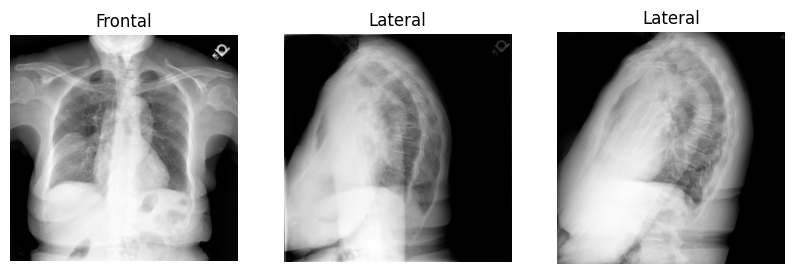

Real report: The heart is normal in size. Atherosclerotic calcifications of the aorta. The mediastinum is stable. There is again soft tissue density projected over the right mid chest, XXXX patient's known large breast mass. The appearance is grossly stable to decreased from prior study. The lateral projection is suboptimal as patient could not raise XXXX. There is no pleural effusion.
Generated report:  XXXX. XXXX opacities in the left lung base. No pneumothorax or pleural effusion. Heart size normal.


In [69]:
uid = 3324
pred = compare_report(uid)
real = get_findings_for_uid(uid)
print(f'Real report: {real}\nGenerated report: {pred}')

In [70]:
for i in range(1, 5):
    weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
    bleu_score = sentence_bleu([real.split()], pred.split(), weights=weights)
    print(f"BLEU-{i} score:", bleu_score)

# METEOR
meteor_scr = meteor_score([real.split()], pred.split())
print("METEOR score:", meteor_scr)

# ROUGE
scores = scorer.score(pred, real)
print("ROUGE-1: ", scores['rouge1'])
print("ROUGE-2: ", scores['rouge2'])
print("ROUGE-L: ", scores['rougeL'])

# BERTScore
P, R, F1 = bert_score([pred], [real], lang="en")
print("BERTScore: ", F1.item())

BLEU-1 score: 0.025519070259378822
BLEU-2 score: 0.01075978477193346
BLEU-3 score: 5.596653159095063e-105
BLEU-4 score: 4.036368402386755e-156
METEOR score: 0.09726348263254113
ROUGE-1:  Score(precision=0.16666666666666666, recall=0.625, fmeasure=0.2631578947368421)
ROUGE-2:  Score(precision=0.01694915254237288, recall=0.06666666666666667, fmeasure=0.02702702702702703)
ROUGE-L:  Score(precision=0.08333333333333333, recall=0.3125, fmeasure=0.13157894736842105)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:  0.8681216835975647


### Проверка на массиве uids

In [71]:
# Initialize the metrics
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []
bert_scores = []

  0%|          | 0/10 [00:00<?, ?it/s]

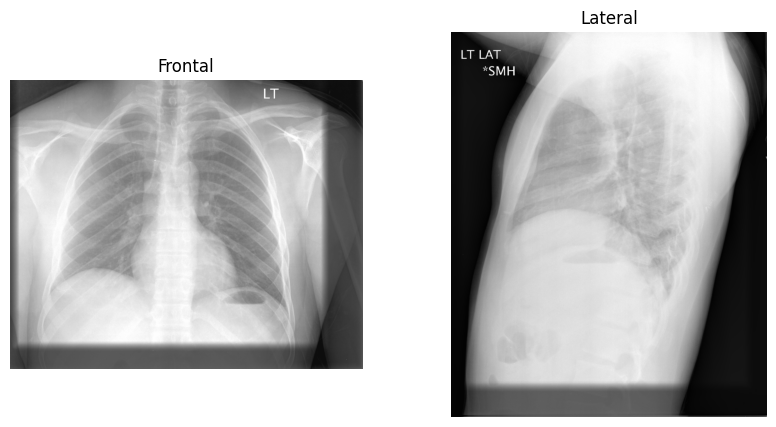

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


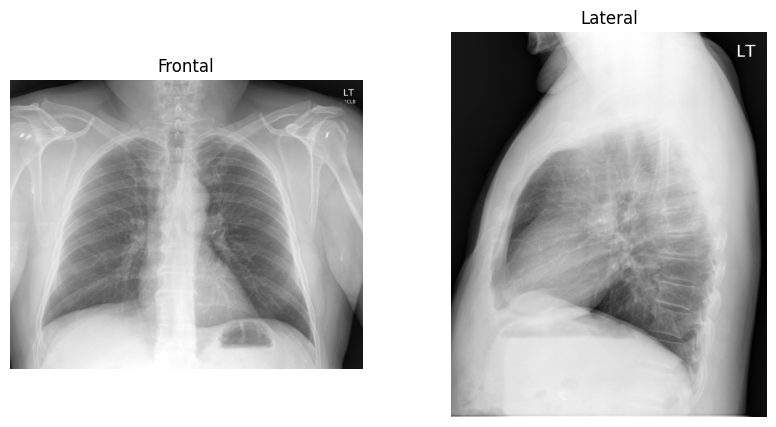

METEOR score: 0.30812362148228856


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


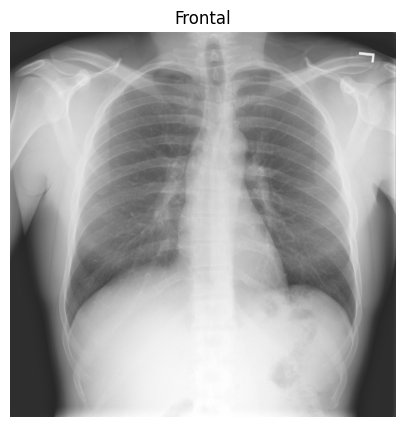

METEOR score: 0.03508771929824562


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


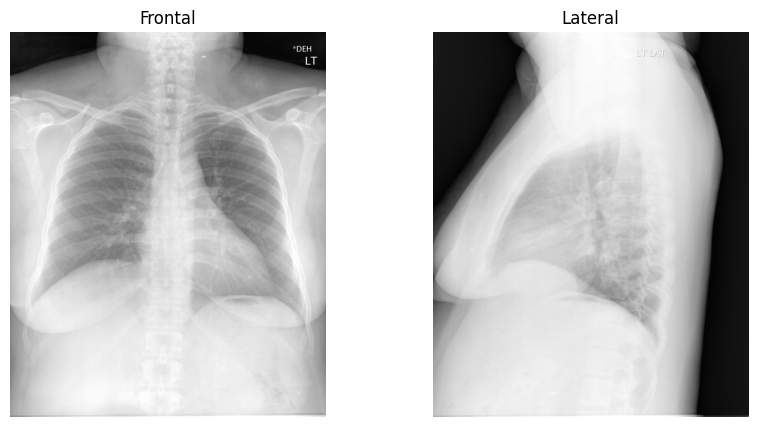

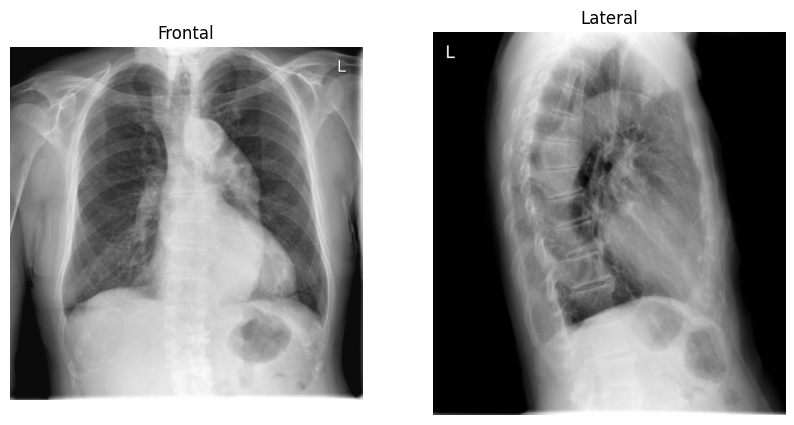

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


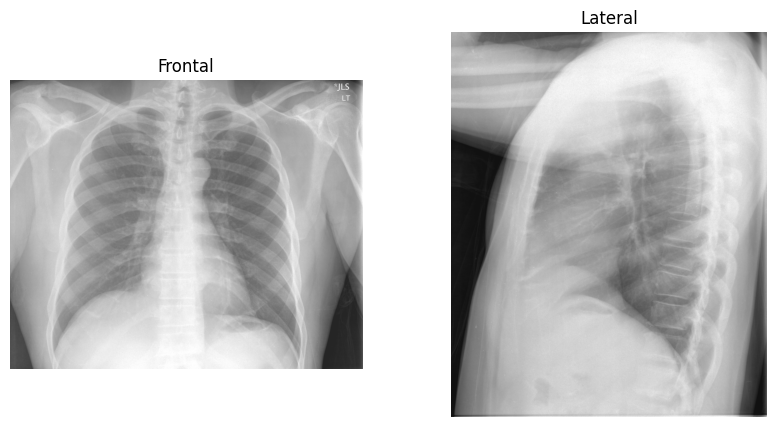

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


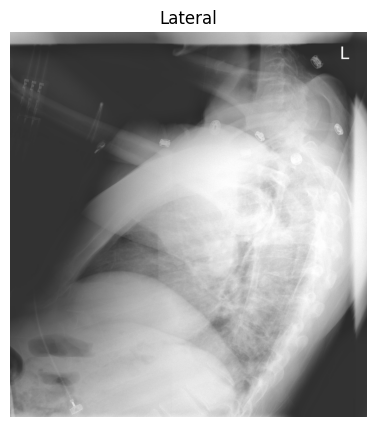

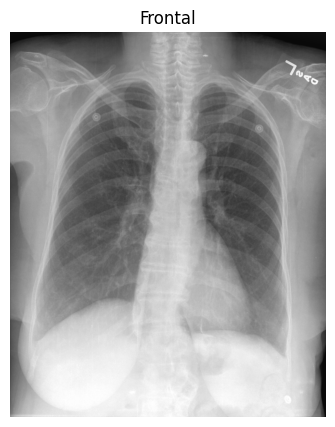

METEOR score: 0.38119658119658123


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


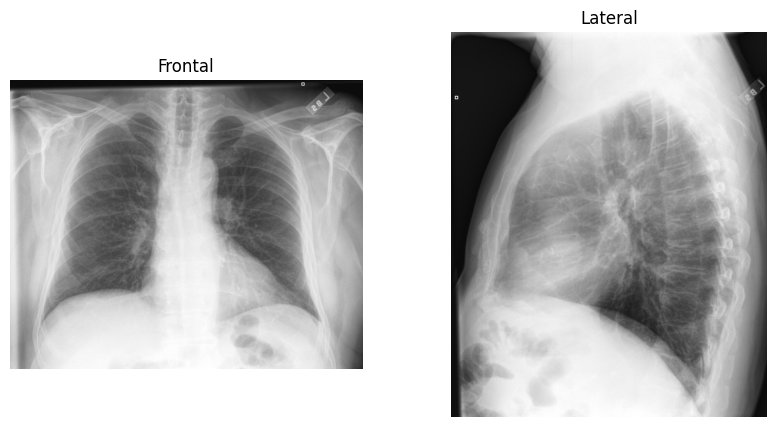

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


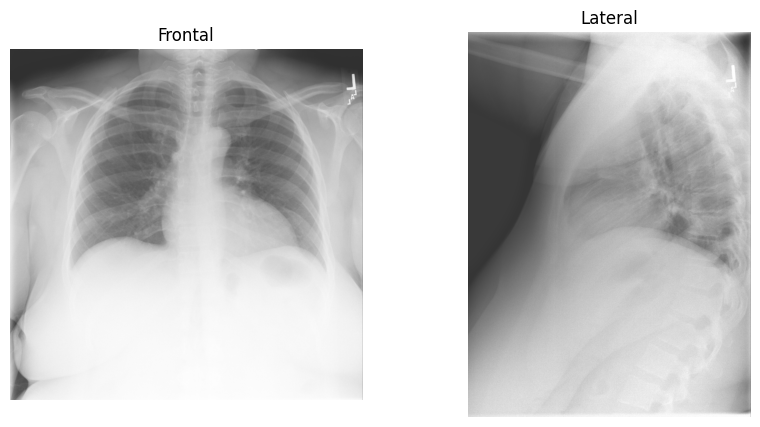

METEOR score: 0.0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# Iterate over all test_uids
for uid in tqdm(test_uids[:10]):
    # Get predicted findings using compare_report function
    predicted_findings = compare_report(uid)
    
    # Get actual findings using get_findings_for_uid function
    actual_findings = get_findings_for_uid(uid)
    
    # Check if both predicted and actual findings are not None
    if predicted_findings is not np.nan and actual_findings is not np.nan:
        # Increment total predictions count
#         bleu_score = sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=weights, smoothing_function=smoothie)
        bleu1_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(1, 0, 0, 0), smoothing_function=smoothie))
        bleu2_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
        bleu3_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
        bleu4_scores.append(sentence_bleu([actual_findings.split()], predicted_findings.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))
        
        # METEOR
        meteor_scr = meteor_score([actual_findings.split()], predicted_findings.split())
        meteor_scores.append(meteor_scr)
        print("METEOR score:", meteor_scr)

        # ROUGE
        scores = scorer.score(predicted_findings, actual_findings)
        rouge1_scores.append(scores['rouge1'])
        rouge2_scores.append(scores['rouge2'])
        rougeL_scores.append(scores['rougeL'])
#         print("ROUGE-1: ", scores['rouge1'])
#         print("ROUGE-2: ", scores['rouge2'])
#         print("ROUGE-L: ", scores['rougeL'])

        # BERTScore
        P, R, F1 = bert_score([predicted_findings], [actual_findings], lang="en")
#         print("BERTScore: ", F1.item())
        bert_scores.append(F1.item())

___

Get average score for 50 random samples

In [ ]:
def compare_report_avg(uid):
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    generated_report = generate_report(image_paths)
    
    # Initialize scorers
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method4

    # BLEU
    bleu_scores = []
    for i in range(1, 5):
        weights = [1/i]*i + [0]*(4-i)  # weights for 1-gram to 4-gram
        bleu_score = sentence_bleu([findings.split()], generated_report.split(), weights=weights, smoothing_function=smoothie)
        bleu_scores.append(bleu_score)
#     bleu_scores.append(bleu_scores_temp)
    
    # METEOR
    meteor_scr = meteor_score([findings.split()], generated_report.split())
    
    # ROUGE
    scores = scorer.score(findings, generated_report)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure

    # BERTScore
    P, R, F1 = bert_score([generated_report], [findings], lang="en")
    bertscore = F1.item()
    
    return bleu_scores, rouge1, rouge2, rougeL, meteor_scr, bertscore

In [ ]:
# Initialize the metrics
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []
bert_scores = []

In [ ]:
# Run the loop and call the function 50 times
for i in range(50):
    try:
        bleu_scores, rouge1, rouge2, rougeL, meteor_scr, bertscore = compare_report_avg(np.random.choice(test_uids))
        bleu1_scores.append(bleu_scores[0])
        bleu2_scores.append(bleu_scores[1])
        bleu3_scores.append(bleu_scores[2])
        bleu4_scores.append(bleu_scores[3])
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)
        meteor_scores.append(meteor_scr)
        bert_scores.append(bertscore)
    except AttributeError as e:
        print(f"Произошла ошибка AttributeError: {e}")
        continue

In [ ]:
bleu1_scores = [x for x in bleu1_scores if x != 0 and x != 0.0]
bleu2_scores = [x for x in bleu2_scores if x != 0 and x != 0.0]
bleu3_scores = [x for x in bleu3_scores if x != 0 and x != 0.0]
bleu4_scores = [x for x in bleu4_scores if x != 0 and x != 0.0]
rouge1_scores = [x for x in rouge1_scores if x != 0 and x != 0.0]
rouge2_scores = [x for x in rouge2_scores if x != 0 and x != 0.0]
rougeL_scores = [x for x in rougeL_scores if x != 0 and x != 0.0]
meteor_scores = [x for x in meteor_scores if x != 0 and x != 0.0]
bert_scores = [x for x in bert_scores if x != 0 and x != 0.0]

In [73]:
# Calculate the average values of the metrics
avg_bleu1 = np.mean(bleu1_scores)
avg_bleu2 = np.mean(bleu2_scores)
avg_bleu3 = np.mean(bleu3_scores)
avg_bleu4 = np.mean(bleu4_scores)
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)
avg_meteor = np.mean(meteor_scores)
avg_bert = np.mean(bert_scores)

In [74]:
print("Average BLEU-1 score:", avg_bleu1)
print("Average BLEU-2 score:", avg_bleu2)
print("Average BLEU-3 score:", avg_bleu3)
print("Average BLEU-4 score:", avg_bleu4)
print("Average ROUGE-1 score:", avg_rouge1)
print("Average ROUGE-2 score:", avg_rouge2)
print("Average ROUGE-L score:", avg_rougeL)
print("Average METEOR score:", avg_meteor)
print("Average BERT score:", avg_bert)

Average BLEU-1 score: 0.06744644904679906
Average BLEU-2 score: 0.049340029066925986
Average BLEU-3 score: 0.03649687228281269
Average BLEU-4 score: 0.02586002342484444
Average ROUGE-1 score: 0.12410607678979291
Average ROUGE-2 score: 0.050373422500438636
Average ROUGE-L score: 0.08459184307426769
Average METEOR score: 0.09055099024713942
Average BERT score: 0.4316864535212517
